# Defect detection in aluminum castings using YOLOv5

Example using series C0001. Training only using ellipsoidal defects. Testing using only real defects. This is not a toy example. The idea is to demonstrate that we can inspect a type of wheel if we train using the images of this wheel with no defects + simulated defects.

Similar to cast_13.ipynb but with more simulated defects.

This example is based on YOLOv5 Tutorial from original GitHub (https://github.com/ultralytics/yolov5)

# Environment Setup
Download and install in Colab required packages and import libraries.

In [1]:
# Select YOLOv5 version 

STABLE_VERSION = 1  # 1 Stable Version of YOLOv5, 29/07/2020, 0 Last available Version from ultralytics

In [2]:
if STABLE_VERSION:
  !wget https://www.dropbox.com/s/6ighkeboex6pf55/yolov5.zip
  !unzip yolov5.zip
  !rm yolov5.zip
  st = 'stable'
else:
  !git clone https://github.com/ultralytics/yolov5  # clone repo
  st = 'last'

!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('YOLOv5 '+st+ ' version downloaded and installed.')
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

YOLOv5 stable version downloaded and installed.
Setup complete. Using torch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Download casting data

Training, validation and testing images and annotations.

In [3]:
# Download training images and annotations
!wget https://www.dropbox.com/s/eocygvnhtaka6j2/cast.zip
!unzip cast.zip
!rm cast.zip
!mv ./cast ../  # move folder alongside /yolov5
!mv ../cast/cast.yaml data/cast.yaml
clear_output()
print('cast.zip unzipped and copied')

cast.zip unzipped and copied


In [4]:
#Setup training parameters

ytype     = 'l' # select 's','m','l', or 'x' for YOLOv5s, ... YOLOv5x
ynew      = 1
yexp      = 0
yrun      = 0
EPOCHS    = 50
CFG       = 'yolov5'+ytype+'.yaml'

if ytype == 'x':
  BATCH = 8
else:
  BATCH = 16    


if ynew:
  TRAIN_WEIGHTS  = 'yolov5'+ytype+'.pt'
else:
  TRAIN_WEIGHTS  = 'runs/exp'+str(yexp)+'/weights/last.pt' 


ytrain    = '--img 640 --batch '+str(BATCH)+' --epochs '+str(EPOCHS)+ ' --data cast.yaml --cfg '+CFG+' --weights '+TRAIN_WEIGHTS+' --nosave --cache'

print('Weights will be stored in : runs/exp'+str(yrun)+'/')
print()
print('Following trining setup will be executed:')

print('>>> !python train.py '+ytrain)

print()
print('If this setup is OK, run next cell, otherwise change parameters')


Weights will be stored in : runs/exp0/

Following trining setup will be executed:
>>> !python train.py --img 640 --batch 16 --epochs 50 --data cast.yaml --cfg yolov5l.yaml --weights yolov5l.pt --nosave --cache

If this setup is OK, run next cell, otherwise change parameters


In [5]:
!python train.py --img 640 --batch {BATCH} --epochs {EPOCHS} --data cast.yaml --cfg {CFG} --weights {TRAIN_WEIGHTS} --nosave --cache

TEST_WEIGHTS = 'runs/exp'+str(yrun)+'/weights/last.pt'
!python test.py --weights {TEST_WEIGHTS} --merge --conf-thres 0.001 --iou-thres 0.5 --data cast.yaml --task test --verbose


Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Namespace(batch_size=16, bucket='', cache_images=True, cfg='./models/yolov5l.yaml', data='./data/cast.yaml', device='', epochs=50, evolve=False, hyp='', img_size=[640, 640], local_rank=-1, multi_scale=False, name='', noautoanchor=False, nosave=True, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5l.pt', world_size=1)
Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
2020-08-05 12:14:17.127581: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'optimizer': 'SGD', 'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv

# Training

Train yolov5 according to cast.yaml

# Visualization

In [6]:
#mAP in testing and validation datasets

#yrun = 0

TEST_WEIGHTS = 'runs/exp'+str(yrun)+'/weights/last.pt'
!python test.py --weights {TEST_WEIGHTS} --merge --conf-thres 0.001 --iou-thres 0.5 --data cast.yaml --task val --verbose
!python test.py --weights {TEST_WEIGHTS} --merge --conf-thres 0.001 --iou-thres 0.5 --data cast.yaml --task test --verbose


Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./data/cast.yaml', device='', img_size=640, iou_thres=0.5, merge=True, save_json=False, save_txt=False, single_cls=False, task='val', verbose=True, weights=['runs/exp0/weights/last.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... Model Summary: 236 layers, 4.73647e+07 parameters, 4.48868e+07 gradients
Scanning labels ../cast/labels/val.cache (1440 found, 0 missing, 0 empty, 0 duplicate, for 1440 images): 100% 1440/1440 [00:00<00:00, 17363.42it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 45/45 [00:35<00:00,  1.28it/s]
                 all    1.44e+03    1.44e+04       0.989       0.993       0.995       0.937
Speed: 18.4/1.6/19.9 ms inference/NMS/total per 640x640 image at batch-size 32
Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./data/cast.yaml', device='', img_size=640, iou_thre

In [7]:
# detection in image(s) of inference/images

!python detect.py --weights {TEST_WEIGHTS} --img 640 --conf 0.35 --source ../cast/images/test/ --save-txt



Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.35, device='', img_size=640, iou_thres=0.5, output='inference/output', save_txt=True, source='../cast/images/test/', update=False, view_img=False, weights=['runs/exp0/weights/last.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... Model Summary: 236 layers, 4.73647e+07 parameters, 4.48868e+07 gradients
image 1/720 /content/cast/images/test/C0001_0001_01.jpg: 640x640 2 defects, Done. (0.032s)
image 2/720 /content/cast/images/test/C0001_0001_02.jpg: 640x640 2 defects, Done. (0.032s)
image 3/720 /content/cast/images/test/C0001_0001_03.jpg: 640x640 1 defects, Done. (0.030s)
image 4/720 /content/cast/images/test/C0001_0001_04.jpg: 640x640 1 defects, Done. (0.029s)
image 5/720 /content/cast/images/test/C0001_0001_05.jpg: 640x640 2 defects, Done. (0.029s)
image 6/720 /content/cast/images/test/C0001_0001_06.jpg: 640x640 2 defects, Done. (0.029s)
image 7/720 /

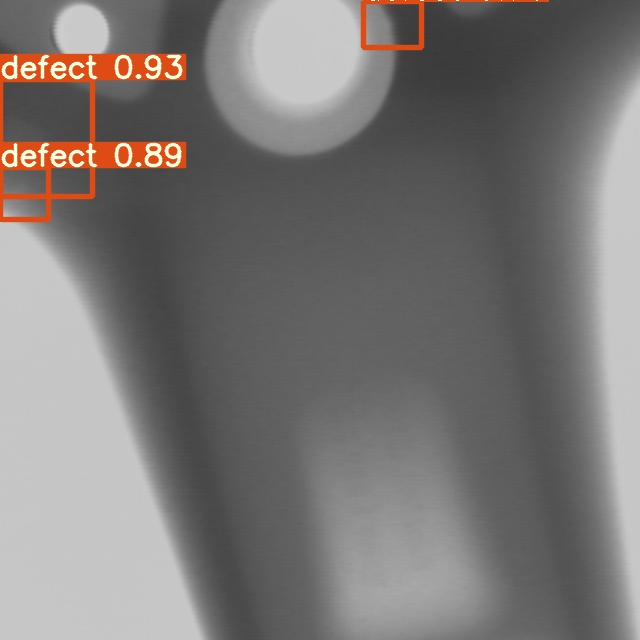

In [8]:
Image(filename='inference/output/C0001_0024_03.jpg', width=600)

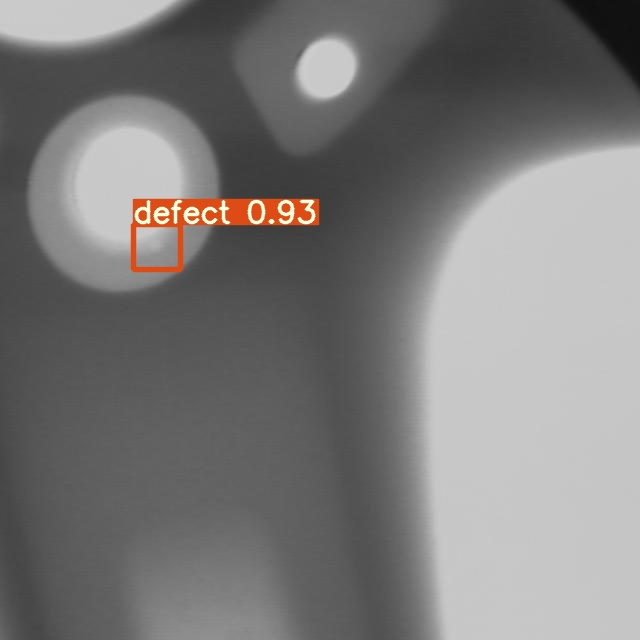

In [9]:
Image(filename='inference/output/C0001_0053_05.jpg', width=600)

In [10]:
!zip -r test_detection zip inference/output/
clear_output()
print('output images zipped in file test_detection.zip')


output images zipped in file test_detection.zip


In [ ]:
# DOWNLOAD RESULTS FROM test_detection.zip

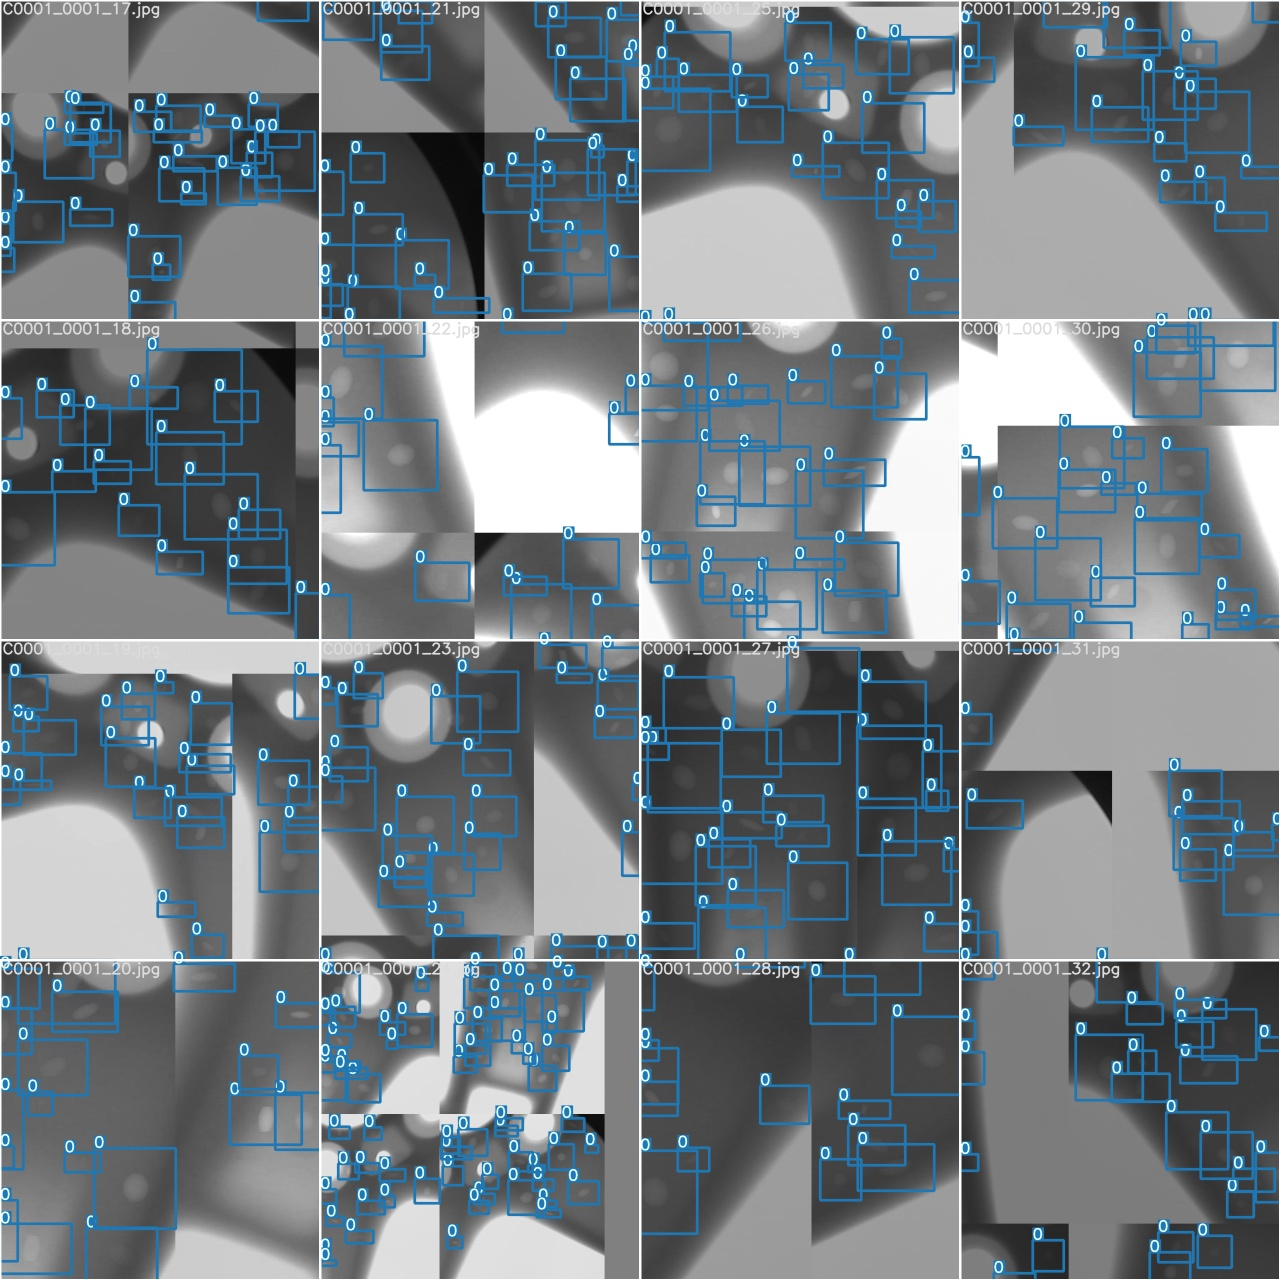

In [11]:
# view augmented training mosaics

Image(filename='runs/exp'+str(yexp)+'/train_batch1.jpg', width=900)  

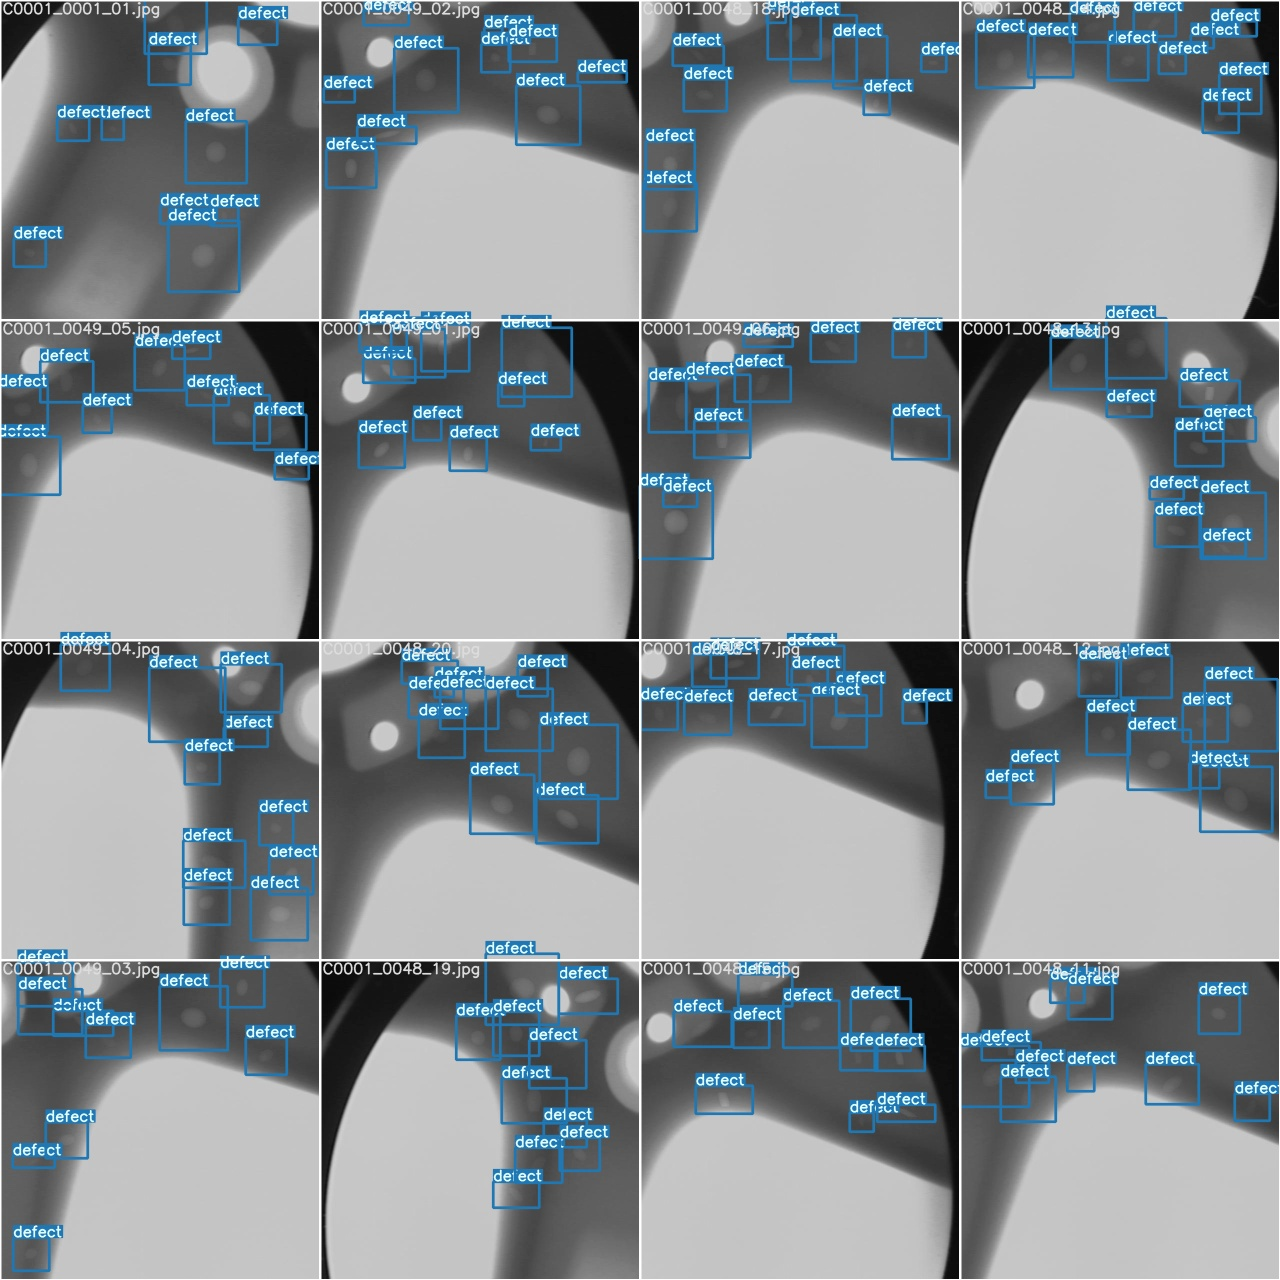

In [12]:
# view test image labels

Image(filename='runs/exp'+str(yexp)+'/test_batch0_gt.jpg', width=900) 

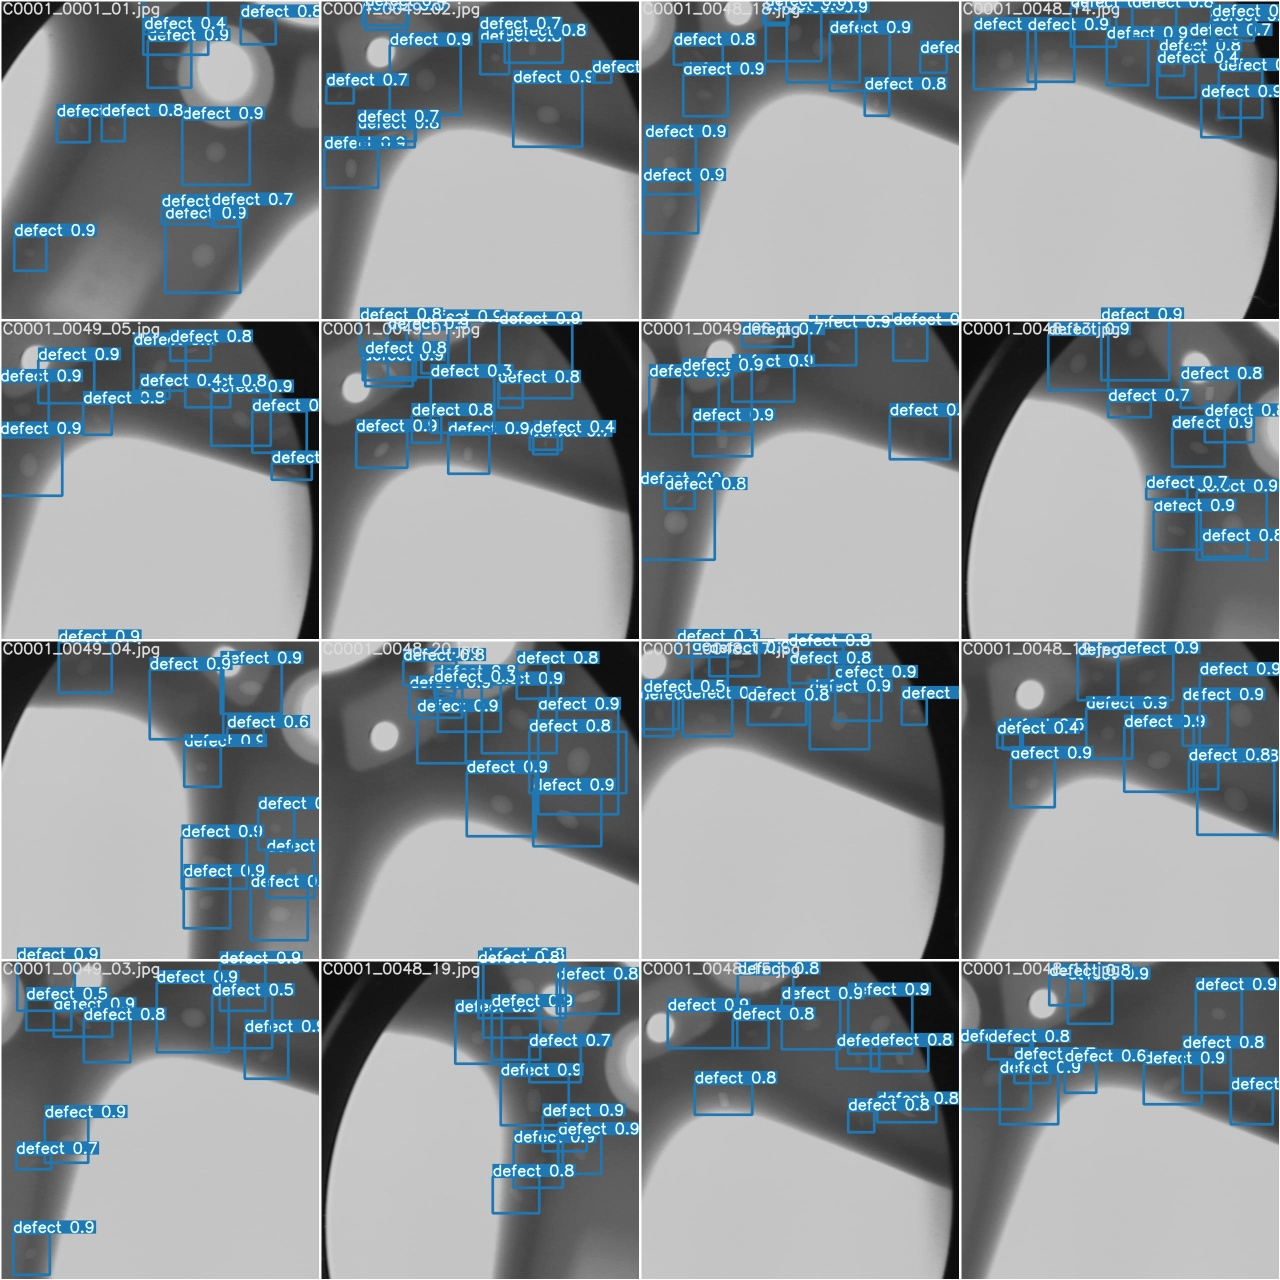

In [13]:
# view test image predictions

Image(filename='runs/exp'+str(yexp)+'/test_batch0_pred.jpg', width=900)  

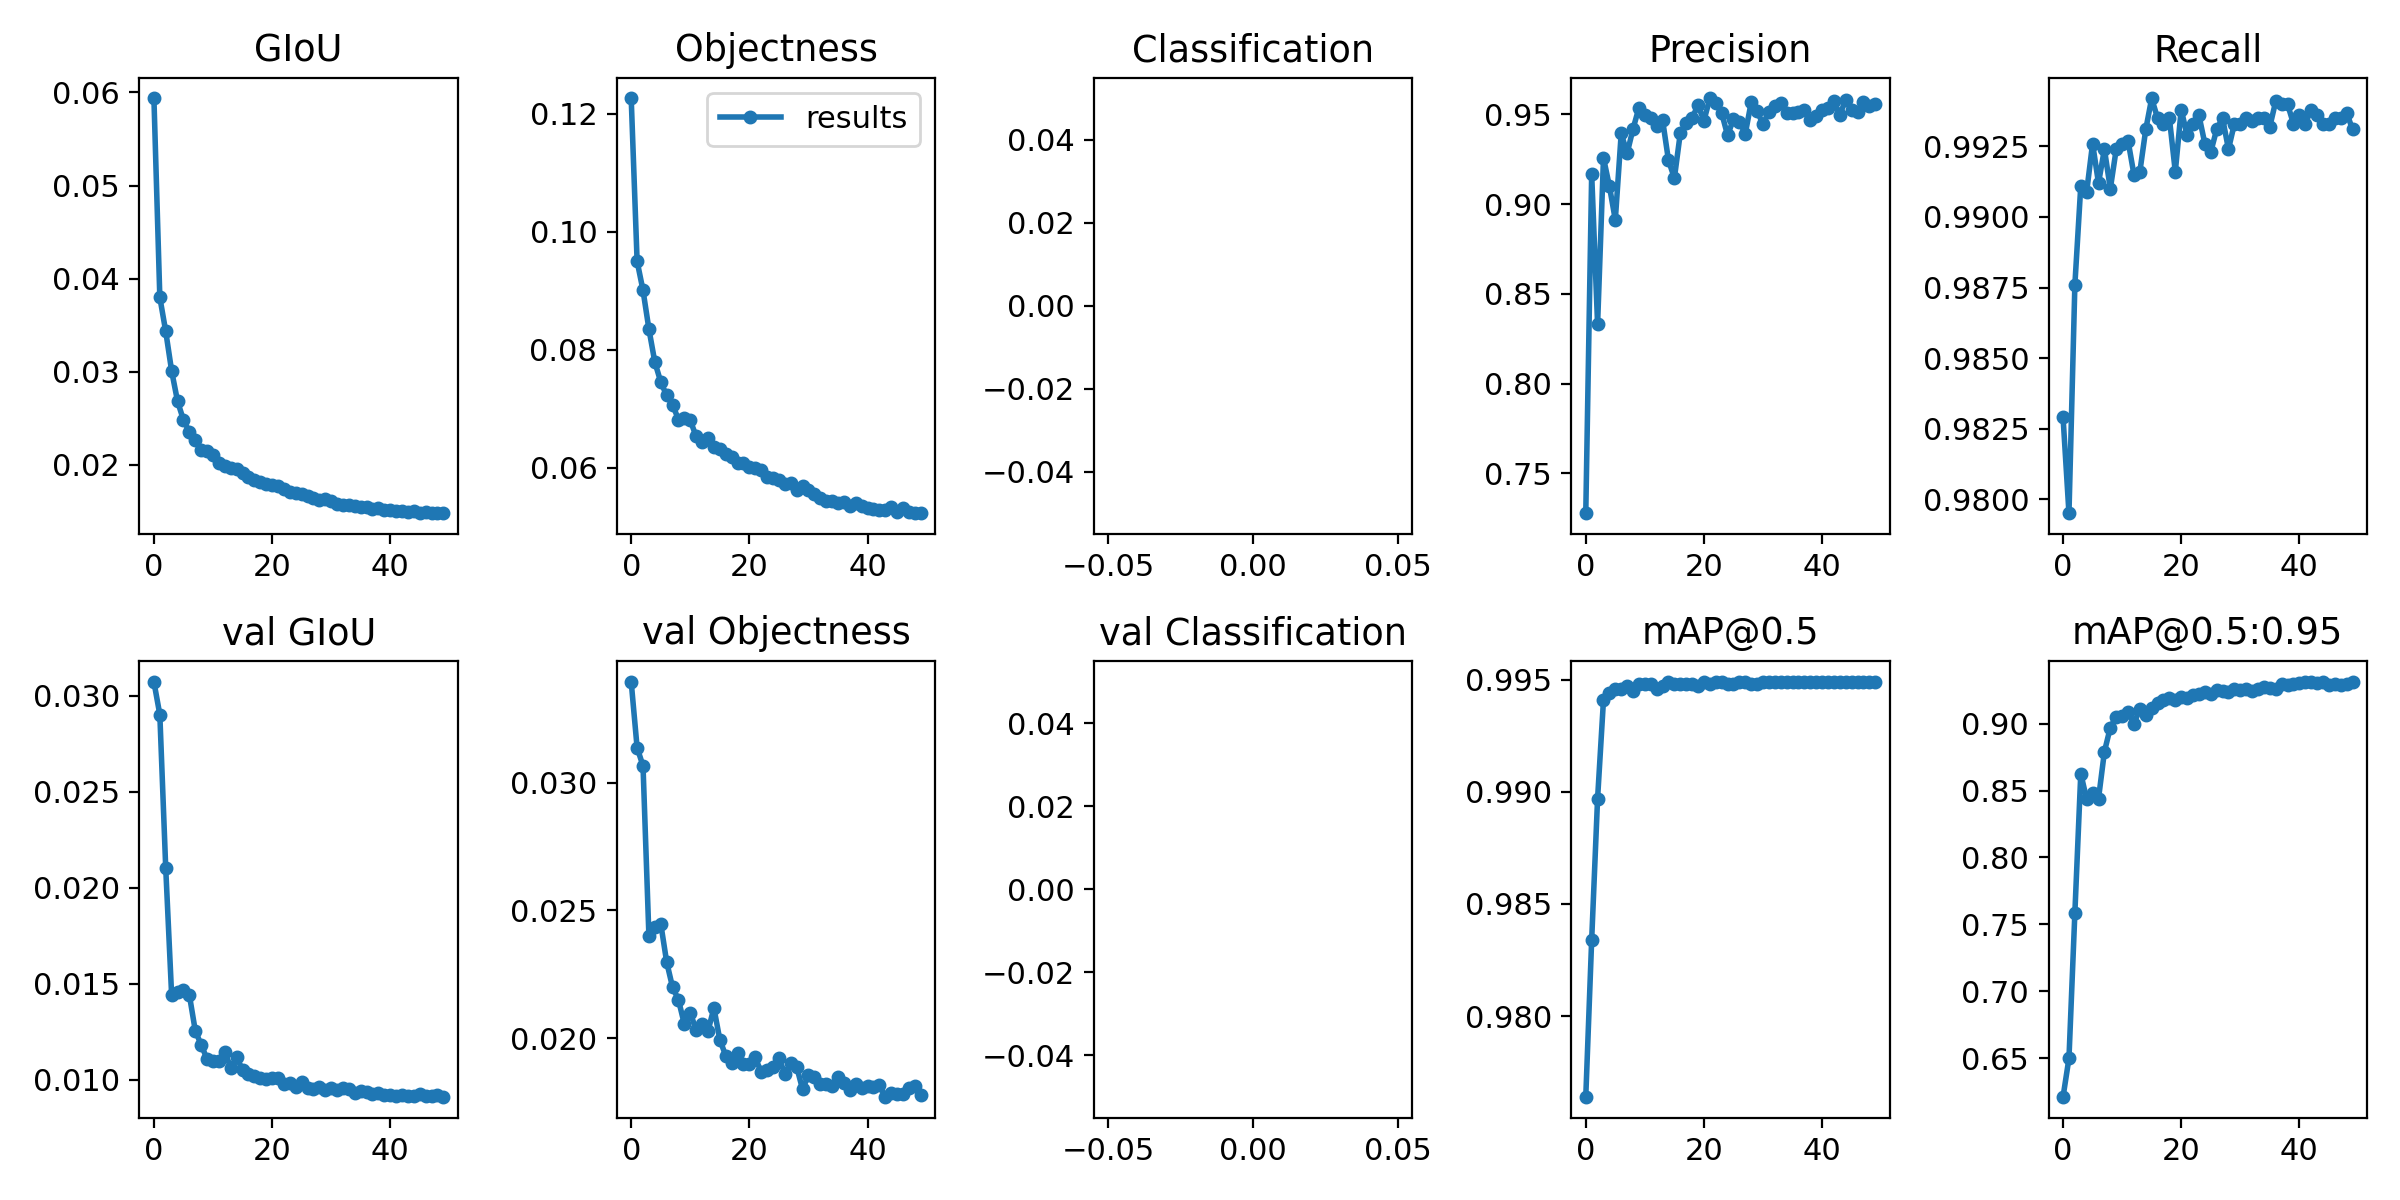

In [14]:
# view training curves

Image(filename='runs/exp'+str(yexp)+'/results.png', width=900)